In [1]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
df = yf.download('MSFT',start='2021-01-01')

[*********************100%***********************]  1 of 1 completed


In [3]:
df['SMA'] = df.Close.rolling(window=20).mean()
df['STD'] = df.Close.rolling(window=20).std()
df = df.dropna()

In [4]:
#https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas
pd.options.mode.chained_assignment = None
df['Upper'] = df.SMA + 2*df.STD
df['Lower'] = df.SMA - 2*df.STD

In [5]:
df['Buy_Signal'] = np.where(df.Lower>df.Close,True,False) # when it is true return false
df['Sell_Signal'] = np.where(df.Upper<df.Close,True,False)

In [6]:
df

,Open,High,Low,Close,Adj Close,Volume,SMA,STD,Upper,Lower,Buy_Signal,Sell_Signal
Date,,,,,,,,,,,,
2021-02-01,235.059998,242.500000,232.429993,239.649994,238.548477,33314200,222.858998,8.723604,240.306207,205.411789,False,False
2021-02-02,241.300003,242.309998,238.690002,239.509995,238.409119,25916300,223.949998,9.382671,242.715339,205.184656,False,False
2021-02-03,239.570007,245.089996,239.259995,243.000000,241.883087,27158100,225.204998,10.175966,245.556929,204.853067,False,False
2021-02-04,242.660004,243.240005,240.369995,242.009995,240.897629,25296100,226.692998,10.356153,247.405304,205.980691,False,False
2021-02-05,242.229996,243.279999,240.419998,242.199997,241.086761,18054800,227.888498,10.709122,249.306741,206.470255,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-29,268.869995,271.649994,267.980011,271.399994,271.399994,19937800,259.005000,6.992108,272.989216,245.020783,False,False
2021-06-30,270.690002,271.359985,269.600006,270.899994,270.899994,21656500,260.184999,6.903614,273.992228,246.377771,False,False
2021-07-01,269.609985,271.839996,269.600006,271.600006,271.600006,16725300,261.479499,6.459592,274.398683,248.560315,False,False


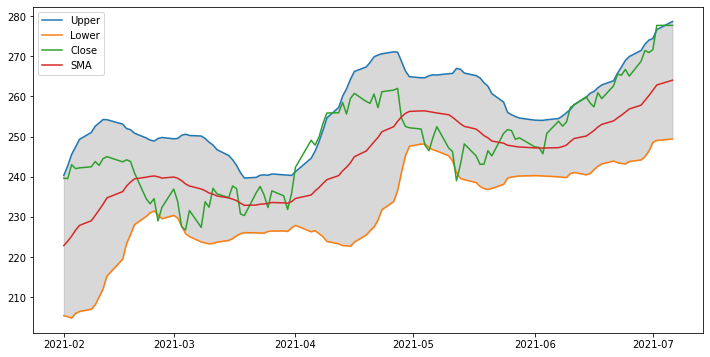

In [7]:
plt.figure(figsize=(12,6))
plt.plot(df[['Upper','Lower','Close','SMA']])
plt.fill_between(df.index,df.Upper,df.Lower,color='grey',alpha=0.3)
plt.legend(['Upper','Lower','Close','SMA'])
plt.show()

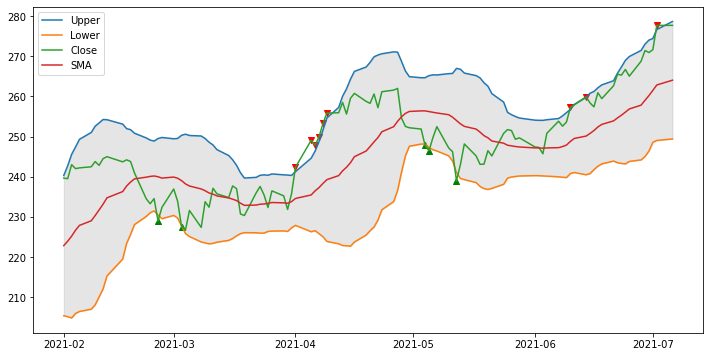

In [8]:
#plot the buy and sell signal
plt.figure(figsize=(12,6))
plt.plot(df[['Upper','Lower','Close','SMA']])
plt.scatter(df.index[df.Buy_Signal],df[df.Buy_Signal].Close, marker = '^', color = 'g') #******* this is very useful and important
plt.scatter(df.index[df.Sell_Signal],df[df.Sell_Signal].Close, marker = 'v', color = 'r') #boolean indexing
plt.fill_between(df.index,df.Upper,df.Lower,color='grey',alpha=0.2)
plt.legend(['Upper','Lower','Close','SMA'])
plt.show()
#but something weird about the signals appears

In [9]:
buys = []
sells = []
open_position = False

for i in range(len(df)):
    if df.Lower[i] > df.Close[i]:
        if not open_position:
            buys.append(i)
            open_position = True
    elif df.Upper[i] < df.Close[i]:
        if open_position:
            sells.append(i)
            open_position = False
        

In [10]:
buys

[17, 64]

In [11]:
sells # buy at one point, sell at one point, ALL IN!!!!!!!!

[42, 90]

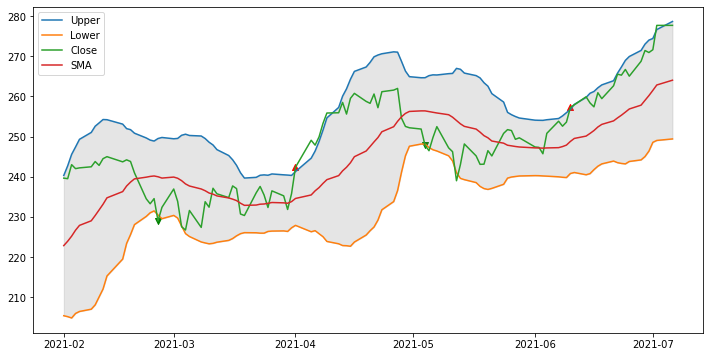

In [12]:
plt.figure(figsize=(12,6))
plt.plot(df[['Upper','Lower','Close','SMA']])
plt.scatter(df.iloc[buys].index,df.iloc[buys].Close, marker = 'v', color = 'g') #******* this is very useful and important
plt.scatter(df.iloc[sells].index,df.iloc[sells].Close, marker = '^', color = 'r') #boolean indexing
plt.fill_between(df.index,df.Upper,df.Lower,color='grey',alpha=0.2)
plt.legend(['Upper','Lower','Close','SMA'])
plt.show()

In [13]:
#Backtesting
merged = pd.concat([df.iloc[buys].Close,df.iloc[sells].Close],axis=1)
merged.columns = ['Buys','Sells']
merged

,Buys,Sells
Date,,
2021-02-25,228.990005,NaN
2021-04-01,NaN,242.350006
2021-05-04,247.789993,NaN
2021-06-10,NaN,257.239990


In [14]:
totalprofits = merged.shift(-1).Sells - merged.Buys
totalprofits
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shift.html

Date
2021-02-25    13.360001
2021-04-01          NaN
2021-05-04     9.449997
2021-06-10          NaN
dtype: float64

In [15]:
relativeProfits = (merged.shift(-1).Sells - merged.Buys)/merged.Buys 
relativeProfits

Date
2021-02-25    0.058343
2021-04-01         NaN
2021-05-04    0.038137
2021-06-10         NaN
dtype: float64

In [16]:
relativeProfits.mean()

0.04824014066112605